Resume Screening With NLP and ML

In [23]:
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer as wnl
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle

In [24]:
df = pd.read_csv("/content/UpdatedResumeDataSet.csv")
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [25]:
df.shape

(962, 2)

In [26]:
df.isnull().sum()

,0
Category,0
Resume,0


In [27]:
df.Resume[598]

'â\x80¢ Operating Systems: Windows â\x80¢ Others: MS Excel, MS Office, MS Power Point Key Projects Handled Project Title: fruit sorting and disease detection Client: Kranti Dynamics Team Size: 5 Education Details \r\nJanuary 2014 B.E. Electronics Mumbai, Maharashtra University of Mumbai\r\nPython Developer/analyst \r\n\r\npython developer and data analyst\r\nSkill Details \r\npython scripting,programming,developing- Exprience - 12 months\r\nfrontend  ,html- Exprience - 12 months\r\npython liabrary, numpy,pandas,matplolib,requests,beautiful soap- Exprience - 12 months\r\nmysql- Exprience - 12 months\r\ndjango- Exprience - 12 months\r\nweb scrapping- Exprience - Less than 1 year monthsCompany Details \r\ncompany - Ace The Power of 5\r\ndescription - The Accountabilities:\r\n\r\nâ\x86\x92 Understanding the functional requirements of the application given by the client.\r\n\r\nâ\x86\x92 Participated in walkthroughs of business requirements, functional requirements and technical design to e

In [35]:
lemmatizer = wnl()
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet') # Add this line to download wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [30]:
def clean_text(text):
    text = text.lower()
    text = re.sub('http\S+\s', ' ', text)
    text = re.sub('RT|cc', ' ', text)
    text = re.sub('#\S+\s', ' ', text)
    text = re.sub('@\S+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\x00-\x7f]', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub('\s+', ' ', text)
    tok_word = list(word_tokenize(text))
    text = [lemmatizer.lemmatize(word) for word in tok_word]
    text = [word for word in text if word not in stop_words and len(word) > 1]
    return ' '.join(text)

In [36]:
df['New_Resume']=df['Resume'].map(lambda x : clean_text(x))

In [37]:
df=df.drop('Resume',axis=1)

In [38]:
df['Category'].value_counts()

,count
Category,
Java Developer,84
Testing,70
DevOps Engineer,55
Python Developer,48
Web Designing,45
HR,44
Hadoop,42
Sales,40
Data Science,40


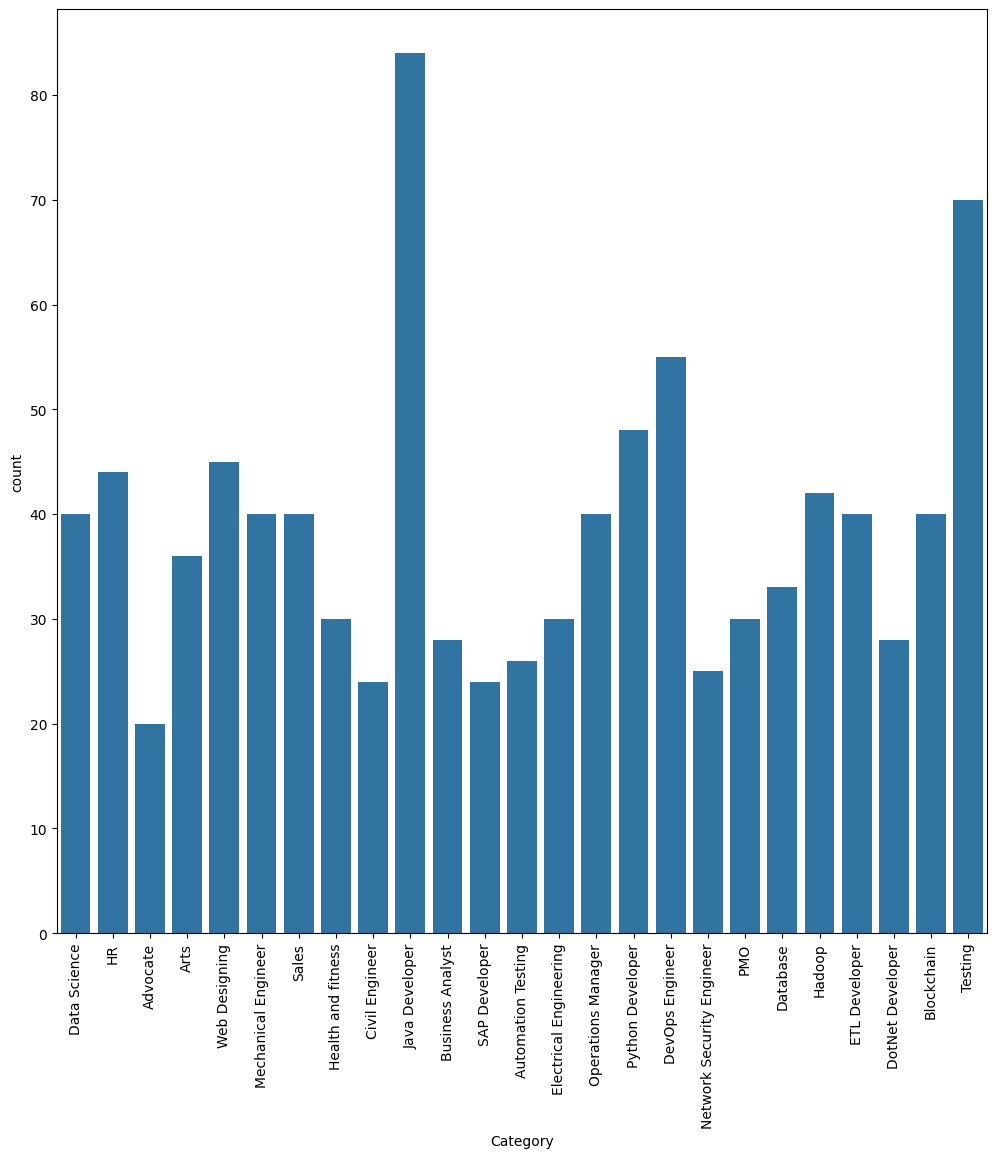

In [39]:
plt.figure(figsize=(12,12))
sns.countplot(x='Category',data=df)
plt.xticks(rotation=90)
plt.show()

In [40]:
tfidf = TfidfVectorizer(stop_words='english')

tfidf.fit(df['New_Resume'])
X = tfidf.transform(df['New_Resume'])

In [41]:
encoder=LabelEncoder()
y=encoder.fit_transform(df['Category'])

In [42]:
x_tr, x_tes, y_tr, y_tes = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42 )

In [43]:
from sklearn.svm import SVC
ovr_clf = OneVsRestClassifier(SVC(kernel='rbf', probability=True, random_state=42))
ovr_clf.fit(x_tr, y_tr)

OneVsRestClassifier(estimator=SVC(probability=True, random_state=42))

In [44]:
y_pred_ovr = ovr_clf.predict(x_tes)

print("Accuracy (OneVsRest + SVC):", accuracy_score(y_tes, y_pred_ovr))

Accuracy (OneVsRest + SVC): 1.0


In [45]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(x_tr, y_tr)

y_pred_rf = rf_clf.predict(x_tes)

print("\nAccuracy (RandomForest):", accuracy_score(y_tes, y_pred_rf))


Accuracy (RandomForest): 1.0


In [46]:
pickle.dump(ovr_clf, open('clf.pkl', 'wb'))
pickle.dump(tfidf,open('tfidf.pkl', 'wb'))
pickle.dump(encoder,open('encoder.pkl', 'wb'))

In [47]:
def predict(text):
    text=clean_text(text)
    vectorized_text = tfidf.transform([text])
    vectorized_text = vectorized_text.toarray()
    predicted_category = ovr_clf.predict(vectorized_text)
    predicted_category_name = encoder.inverse_transform(predicted_category)
    return predicted_category_name[0]